In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from pprint import pprint
import numpy as np
from dicomhd import io as dhd_io
from medpy.io import load as load_lbl
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Fucntion to extract image and label pathces
def extract_3D_patch(images, ksizes=[1, 15, 24, 24, 1], strides=[1, 7, 12, 12, 1]):
    # convert image data to tensor
    imgs = np.expand_dims(images, [0, -1])
    t_imgs = tf.convert_to_tensor(imgs, dtype='float32')
    # Extract voulm patches: 30x48x48
    t_patches = tf.extract_volume_patches(
        t_imgs,
        ksizes=ksizes,
        strides=strides,
        padding='SAME'
    )
    img_patches = tf.reshape(t_patches, (-1 ,15, 24, 24, 1))
   
    return img_patches


In [30]:
#function to extract pathces with annoations
def extract_patch_labels(t_lbl_patches, method='max', ratio_th=0.2):
    if method == 'max':
        t_patch_labels = tf.reduce_max(t_lbl_patches, axis=[1,2,3,4])
    elif method == 'ratio':
        ratio_ann_voxels = tf.math.count_nonzero(tlbl_patches, axis=[1,2,3,4]) / (15*24*24)
        mask = ratio_ann_voxels < ratio_th
        t_patch_labels = tf.reduce_max(t_lbl_patches, axis=[1,2,3,4])
        t_patch_labels = tf.where(mask, tf.zeros(tf.shape(t_patch_labels)), t_patch_labels)
    elif method == 'center':
        raise NotImplementedError
    else:
        raise ValueError('Invalid label extraction method!')
    
    return t_patch_labels

def extract_annotated_patch(t_img_patches,t_lbl_patches):
    # get patch labels
    t_patch_labels = extract_patch_labels(t_lbl_patches, 'ratio')
    mask = t_patch_labels > 0
    t_lbl_patches_with_annotation = tf.boolean_mask(t_lbl_patches, mask, axis=0)
    t_patch_img_with_annotation = tf.boolean_mask(t_img_patches, mask, axis=0)
    t_patch_lbl_with_annotation = tf.boolean_mask(t_patch_labels, mask, axis = 0)
    return t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [27]:
# read all labeld images from directory and generate label patches
#get filenames for images
with tf.device('/cpu:0'):
    
    store_as_tfrecord = True
    store_as_dataset = False
    
    path_img = '../../../data/train/input/complete/'
    path_lbl = '../../../data/train/output/complete/'
    out_path = '../../../data/lta/tfrecods/'
    out_fname = 'train'
    if store_as_tfrecord:
        out_ffname = os.path.join(out_path, out_fname + '.tfrecords')
    
    img_fnames = sorted([f for f in os.listdir(path_img)])
    img_fnames.remove('.DS_Store')
    list_img_patches = []
    # get filename for labels
    lbl_fnames = sorted([f for f in os.listdir(path_lbl)])
    lbl_fnames.remove('.DS_Store')
    list_lbl_patches = []

    n_rows = 24
    n_cols = 24
    n_planes = 15
    
    
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    if store_as_tfrecord:
        # create tfrecord writer instance
        writer = tf.io.TFRecordWriter(out_ffname)
    n_samples = 0
    for img_fname, lbl_fname in zip(img_fnames, lbl_fnames):
        print(img_fname, ',',lbl_fname)
        # extract lable patches
        lbl_file_path = os.path.join(path_lbl, lbl_fname)
        lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
        lbl, label_header = load_lbl(lbl_file_path)
        lbl = np.swapaxes(lbl,0,2)
        if lbl.sum() > 0:
            # get indices for voxels with ann
            idx_with_ann = np.ma.where(lbl.sum(axis=(1,2)) > 0)[0]
            # crop label
#             lbl_ann = lbl[idx_with_ann.min():idx_with_ann.max()+1, ...]
            tlbl_patches = extract_3D_patch(lbl)
    
        
            # load image
            img_file_path = os.path.join(path_img, img_fname)
            img = dhd_io.read_series(img_file_path).pixel_data
            # crop image
#             img_ann=images.pixel_data[idx_with_ann.min():idx_with_ann.max()+1, ...]
            # extract image patches
            timg_patches = extract_3D_patch(img)
            
            
            timg_patches_with_ann, tlbl_patches_with_ann, tpatch_lbls_with_ann = \
                extract_annotated_patch(timg_patches, tlbl_patches)
            break
            if store_as_dataset:
                list_lbl_patches.append(tlbl_patches)
                list_img_patches.append(timg_patches)
            
            if store_as_tfrecord:
                for patch_idx in range(timg_patches_with_ann.shape[0]):
            
                    timg_patch_idx = timg_patches_with_ann[patch_idx, ...]
                    tlbl_patch_idx = tlbl_patches_with_ann[patch_idx, ...]
                    tpatch_lbl_idx = tpatch_lbls_with_ann[patch_idx, ...]
                    example = tf.train.Example(
                        features=tf.train.Features(feature={
                            'height': _int64_feature(n_rows),
                            'width': _int64_feature(n_cols),
                            'depth': _int64_feature(n_planes),
                            'lbl': _int64_feature(int(tpatch_lbl_idx.numpy())),
                            'img': _bytes_feature(tf.io.serialize_tensor(timg_patch_idx).numpy()),
                        })
                                              )
                    writer.write(example.SerializeToString())
                    
                    
            n_samples += timg_patches_with_ann.shape[0]
            print('image dim:', img.shape, 'label dim:', lbl.shape)
            print(f'patch dim: {timg_patches_with_ann.shape}, patch lbl dim: {tlbl_patches_with_ann.shape}')
            print('-' * 50)
    
    if store_as_tfrecord:
        writer.close()
        
    if store_as_dataset:
        # read all labeld images from directory and generate label patches
        stack_img_patches = tf.concat(list_img_patches, axis=0)
        stack_lbl_patches = tf.concat(list_lbl_patches, axis=0)
        print(f'shape of stack images: {stack_img_patches.shape}')
        print(f'shape of stack labels: {stack_lbl_patches.shape}')

Honeycomb-013710-Joe_reviewed_1-279 , Honeycomb-013710-Joe_reviewed_1-452


### Extract validation patches

In [28]:
# print(tlbl_patches.shape)
# ratio_ann_voxels = tf.math.count_nonzero(tlbl_patches, axis=[1,2,3,4],) / (15*24*24)
# ratio_ann_voxels.numpy()

In [29]:
timg_patches_with_ann.shape

TensorShape([804, 15, 24, 24, 1])

In [17]:
mask = ratio_ann_voxels > 0
x = tf.boolean_mask(ratio_ann_voxels, mask).numpy()

In [18]:
x.shape

(804,)

(array([210., 100.,  74.,  56.,  39.,  29.,  25.,  23.,  29.,  20.,  13.,
         22.,  10.,  15.,  12.,  19.,  11.,  21.,   8.,   7.,  10.,   7.,
          5.,   1.,  10.,   2.,   3.,   4.,   9.,   3.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   1.,   1.]),
 array([1.15740741e-04, 1.57523148e-02, 3.13888889e-02, 4.70254630e-02,
        6.26620370e-02, 7.82986111e-02, 9.39351852e-02, 1.09571759e-01,
        1.25208333e-01, 1.40844907e-01, 1.56481481e-01, 1.72118056e-01,
        1.87754630e-01, 2.03391204e-01, 2.19027778e-01, 2.34664352e-01,
        2.50300926e-01, 2.65937500e-01, 2.81574074e-01, 2.97210648e-01,
        3.12847222e-01, 3.28483796e-01, 3.44120370e-01, 3.59756944e-01,
        3.75393519e-01, 3.91030093e-01, 4.06666667e-01, 4.22303241e-01,
        4.37939815e-01, 4.53576389e-01, 4.69212963e-01, 4.84849537e-01,
        5.00486111e-01, 5.16122685e-01, 5.31759259e-01, 5.47395833e-01,
        5.

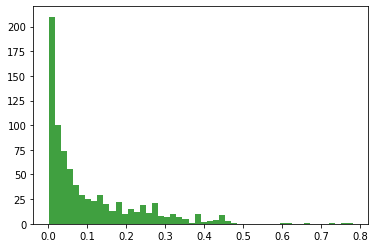

In [19]:
plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)


In [9]:
# read all labeld images from directory and generate label patches
#get filenames for images
with tf.device('/cpu:0'):
    
    store_as_tfrecord = True
    store_as_dataset = False
    
    path_img = '../../../data/val/input/complete/'
    path_lbl = '../../../data/val/output/complete/'
    out_path = '../../../data/lta/tfrecods/'
    out_fname = 'val'
    if store_as_tfrecord:
        out_ffname = os.path.join(out_path, out_fname + '.tfrecords')
    
    img_fnames = sorted([f for f in os.listdir(path_img)])
    img_fnames.remove('.DS_Store')
    list_img_patches = []
    # get filename for labels
    lbl_fnames = sorted([f for f in os.listdir(path_lbl)])
    lbl_fnames.remove('.DS_Store')
    list_lbl_patches = []

    n_rows = 24
    n_cols = 24
    n_planes = 15
    
    
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    if store_as_tfrecord:
        # create tfrecord writer instance
        writer = tf.io.TFRecordWriter(out_ffname)
    n_samples = 0
    for img_fname, lbl_fname in zip(img_fnames, lbl_fnames):
        print(img_fname, ',',lbl_fname)
        # extract lable patches
        lbl_file_path = os.path.join(path_lbl, lbl_fname)
        lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
        lbl, label_header = load_lbl(lbl_file_path)
        lbl = np.swapaxes(lbl,0,2)
        if lbl.sum() > 0:
            # get indices for voxels with ann
            idx_with_ann = np.ma.where(lbl.sum(axis=(1,2)) > 0)[0]
            # crop label
#             lbl_ann = lbl[idx_with_ann.min():idx_with_ann.max()+1, ...]
            tlbl_patches = extract_3D_patch(lbl)
            # load image
            img_file_path = os.path.join(path_img, img_fname)
            img = dhd_io.read_series(img_file_path).pixel_data
            # crop image
#             img_ann=images.pixel_data[idx_with_ann.min():idx_with_ann.max()+1, ...]
            # extract image patches
            timg_patches = extract_3D_patch(img)
            
            
            timg_patches_with_ann, tlbl_patches_with_ann, tpatch_lbls_with_ann = \
                extract_annotated_patch(timg_patches, tlbl_patches)
            if store_as_dataset:
                list_lbl_patches.append(tlbl_patches)
                list_img_patches.append(timg_patches)
            
            if store_as_tfrecord:
                for patch_idx in range(timg_patches_with_ann.shape[0]):
            
                    timg_patch_idx = timg_patches_with_ann[patch_idx, ...]
                    tlbl_patch_idx = tlbl_patches_with_ann[patch_idx, ...]
                    tpatch_lbl_idx = tpatch_lbls_with_ann[patch_idx, ...]
                    example = tf.train.Example(
                        features=tf.train.Features(feature={
                            'height': _int64_feature(n_rows),
                            'width': _int64_feature(n_cols),
                            'depth': _int64_feature(n_planes),
                            'lbl': _int64_feature(int(tpatch_lbl_idx.numpy())),
                            'img': _bytes_feature(tf.io.serialize_tensor(timg_patch_idx).numpy()),
                        })
                                              )
                    writer.write(example.SerializeToString())
                    
                    
            n_samples += timg_patches_with_ann.shape[0]
            print('image dim:', img.shape, 'label dim:', lbl.shape)
            print(f'patch dim: {timg_patches_with_ann.shape}, patch lbl dim: {tlbl_patches_with_ann.shape}')
            print('-' * 50)
    
    if store_as_tfrecord:
        writer.close()
        
    if store_as_dataset:
        # read all labeld images from directory and generate label patches
        stack_img_patches = tf.concat(list_img_patches, axis=0)
        stack_lbl_patches = tf.concat(list_lbl_patches, axis=0)
        print(f'shape of stack images: {stack_img_patches.shape}')
        print(f'shape of stack labels: {stack_lbl_patches.shape}')

Honeycomb-068c5d-Joe_reviewed_1-281 , Honeycomb-068c5d-Joe_reviewed_1-446
image dim: (234, 512, 512) label dim: (234, 512, 512)
patch dim: (208, 15, 24, 24, 1), patch lbl dim: (208, 15, 24, 24, 1)
--------------------------------------------------
Honeycomb-068c5d-Samir_reviewed_1-320 , Honeycomb-068c5d-Samir_reviewed_1-368
image dim: (234, 512, 512) label dim: (234, 512, 512)
patch dim: (428, 15, 24, 24, 1), patch lbl dim: (428, 15, 24, 24, 1)
--------------------------------------------------
Honeycomb-5a2c14-Joe_reviewed_1-284 , Honeycomb-5a2c14-Joe_reviewed_1-413
image dim: (971, 512, 512) label dim: (971, 512, 512)
patch dim: (184, 15, 24, 24, 1), patch lbl dim: (184, 15, 24, 24, 1)
--------------------------------------------------
Honeycomb-5a2c14-Samir_reviewed_1-327 , Honeycomb-5a2c14-Samir_reviewed_1-362
image dim: (971, 512, 512) label dim: (971, 512, 512)
patch dim: (845, 15, 24, 24, 1), patch lbl dim: (845, 15, 24, 24, 1)
--------------------------------------------------


In [ ]:
# nm of paptches in each class
classes = {1: 'normal', 
          2: 'hyperlucnet',
          3: 'groundglass',
          4: 'reticular',
          5: 'honeycomb',
          6: 'consolidation'}
t = np.array(t_patch_lbl_with_annotation)
print(t.shape)
for i in range(1,7):
    print(f'class {classes[i]} has {t[t==i].shape[0]} patches')
    


#### 